In [1]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
# import uproot
import ROOT
import coffea
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

In [2]:
single = '/eos/user/b/bbapi/CMSSW_13_3_1_patch1/src/NanoAODProduction/NanoAODv13/test/M20-RunIISummer20UL18NanoAODv2/B7D21F37-159B-4F42-B1A8-97F4732749B9.root'

In [ ]:
factory = NanoEventsFactory.from_root(
    f"{single}:Events",
    schemaclass=NanoAODSchema,
)
events = factory.events()

events = ak.materialize(events)
photons = events.Photon


In [5]:
photons = events.Photon

In [7]:
photons.fields

['seediEtaOriX',
 'cutBased',
 'electronVeto',
 'hasConversionTracks',
 'isScEtaEB',
 'isScEtaEE',
 'mvaID_WP80',
 'mvaID_WP90',
 'pixelSeed',
 'seedGain',
 'electronIdx',
 'jetIdx',
 'nSaturatedXtals',
 'numberOfClusters',
 'seediPhiOriY',
 'vidNestedWPBitmap',
 'chargedHadronIso',
 'dEscaleDown',
 'dEscaleUp',
 'dEsigmaDown',
 'dEsigmaUp',
 'e2nd',
 'e2x5Bottom',
 'e2x5Left',
 'e2x5Right',
 'e2x5Top',
 'e2x5max',
 'e5x5',
 'eBottom',
 'eCorr',
 'eLeft',
 'eMax',
 'eRight',
 'eTop',
 'ecalPFClusterIso',
 'ecalRecHitIsolation',
 'energy',
 'energyErr',
 'energyRaw',
 'esEffSigmaRR',
 'esEnergyOverRawE',
 'eta',
 'etaWidth',
 'hadTowOverEm',
 'haloTaggerMVAVal',
 'hcalPFClusterIso',
 'hoe',
 'mvaID',
 'pfChargedIso',
 'pfChargedIsoPFPV',
 'pfChargedIsoWorstVtx',
 'pfPhoIso03',
 'pfRelIso03_all',
 'pfRelIso03_chg',
 'phi',
 'phiWidth',
 'pt',
 'r9',
 'r9Frac',
 'rawPreshowerEnergy',
 's4',
 'seedClusEnergy',
 'seedClusterEta',
 'seedClusterPhi',
 'sieie',
 'sieip',
 'sigmaIetaIetaFrac',


In [ ]:
#!/usr/bin/env python3
import os
import argparse
import awkward as ak
import ROOT
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

ROOT.gStyle.SetOptStat(0)
ROOT.gROOT.SetBatch(True)


def plot_histogram(varname, values, bins, title, legend, outdir, outroot):
    nbins, xmin, xmax = bins
    hname = f"h_{varname}"
    hist = ROOT.TH1F(hname, title, nbins, xmin, xmax)
    hist.GetXaxis().SetTitle(title)
    hist.GetYaxis().SetTitle("Events")

    # Flatten awkward array to 1D
    values_flat = ak.flatten(values, axis=None)
    for val in values_flat:
        hist.Fill(val)

    # Canvas
    c = ROOT.TCanvas(f"c_{varname}", "", 800, 700)
    hist.SetLineWidth(2)
    hist.SetLineColor(ROOT.kBlue + 1)
    hist.Draw("HIST")

    legend_box = ROOT.TLegend(0.65, 0.75, 0.88, 0.88)
    legend_box.AddEntry(hist, legend, "l")
    legend_box.Draw()

    if not os.path.exists(outdir):
        os.makedirs(outdir)

    pdf_path = os.path.join(outdir, f"{varname}.pdf")
    png_path = os.path.join(outdir, f"{varname}.png")
    c.SaveAs(pdf_path)
    c.SaveAs(png_path)

    outroot.cd()
    hist.Write()
    c.Close()


def main():
    parser = argparse.ArgumentParser(description="Plot photon fields from Coffea NanoEvents")
    parser.add_argument("--input", required=True, help="Input ROOT file (NanoAOD)")
    parser.add_argument("--outdir", required=True, help="Output directory for plots")
    parser.add_argument("--listfile", help="Optional Python file defining plot_list[]")
    args = parser.parse_args()

    # Default list
    plot_list = [
        {"var": "pt", "bins": (100, 0, 200), "title": "Photon p_{T} [GeV]", "legend": "Photon pT"},
        {"var": "eta", "bins": (60, -3, 3), "title": "Photon #eta", "legend": "Photon eta"},
        {"var": "phi", "bins": (64, -3.2, 3.2), "title": "Photon #phi", "legend": "Photon phi"},
    ]

    if args.listfile:
        import importlib.util
        spec = importlib.util.spec_from_file_location("plotlist", args.listfile)
        plotlist_module = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(plotlist_module)
        plot_list = plotlist_module.plot_list

    # Load NanoEvents
    print(f"Loading {args.input}")
    factory = NanoEventsFactory.from_root(
        f"{args.input}:Events",
        schemaclass=NanoAODSchema,
    )
    events = factory.events()
    events = ak.materialize(events)

    # Extract photons
    photons = events.Photon
    print(f"Loaded {len(events)} events, {ak.num(photons)} photons/event (avg {ak.mean(ak.num(photons)):.2f})")

    # Prepare output ROOT
    if not os.path.exists(args.outdir):
        os.makedirs(args.outdir)
    outroot_path = os.path.join(args.outdir, "photon_plots.root")
    outroot = ROOT.TFile(outroot_path, "RECREATE")

    # Loop over plots
    for cfg in plot_list:
        varname = cfg["var"]
        print(f"Plotting {varname} ...")
        try:
            values = getattr(photons, varname)
        except AttributeError:
            print(f"Warning: Variable '{varname}' not found in Photon branch. Skipping.")
            continue
        plot_histogram(varname, values, cfg["bins"], cfg["title"], cfg["legend"], args.outdir, outroot)

    outroot.Close()
    print(f"All plots saved to:")
    print(f"   → ROOT file: {outroot_path}")
    print(f"   → PDF/PNG:   {args.outdir}/")


if __name__ == "__main__":
    main()


In [9]:
def delta_r_manual(obj1, obj2):
    deta = obj1.eta[:, None] - obj2.eta
    dphi = np.abs(obj1.phi[:, None] - obj2.phi)
    dphi = ak.where(dphi > np.pi, 2 * np.pi - dphi, dphi)
    return np.sqrt(deta**2 + dphi**2)

In [42]:
gen = events.GenPart

gen_photons = gen[(gen.pdgId == 22) & (gen.status == 1)]

mother_idx = gen_photons.genPartIdxMother
from_a_mask = gen[mother_idx].pdgId == 35
gen_photons_from_a = gen_photons[from_a_mask]

photons = events.Photon 

abs_eta = np.abs(photons.eta)

# Barrel–endcap transition exclusion (1.442 ≤ |η| ≤ 1.566)
valid_eta = (abs_eta <= 2.5) & ~((abs_eta >= 1.442) & (abs_eta <= 1.566))

# Barrel vs Endcap ID cuts
is_barrel = abs_eta < 1.442
is_endcap = (abs_eta > 1.566) & (abs_eta < 2.5)

# Apply region-specific MVA thresholds
barrel_cut = is_barrel & (photons.mvaID > -0.02)
endcap_cut = is_endcap & (photons.mvaID > -0.26)

# Combine everything
good_photons = (
    (photons.pt > 10)
    & valid_eta
    & (barrel_cut | endcap_cut)
    & (~photons.pixelSeed)
)

# good_photons = (
#     (photons.pt > 10)
#     & (np.abs(photons.eta) < 2.5)
#     & (photons.mvaID > -0.02)
# )
selected_photons = photons[good_photons]
at_least_two_photons = ak.num(selected_photons) >= 2

# dR_before = delta_r_manual(photons, gen_photons_from_a)
# --- sort photons by descending pT ---
ordered_photons_before = photons[ak.argsort(photons.pt, axis=1, ascending=False)]

# # --- leading and subleading photons ---
# lead_photon = ak.firsts(ordered_photons)
# sublead_photon = ak.firsts(ordered_photons[:, 1])

# pad each event to have at least 2 entries
ordered_photons_padded_before = ak.pad_none(ordered_photons_before, 2)  

# leading and subleading photons
lead_photon_before = ak.firsts(ordered_photons_padded_before)      # first photon
sublead_photon_before = ordered_photons_padded_before[:, 1] 

dR_before_lead = delta_r_manual(lead_photon_before, gen_photons_from_a)
dR_before_sublead = delta_r_manual(sublead_photon_before, gen_photons_from_a)

empty_photons = ak.Array([[]] * len(events))

event_mask = at_least_two_photons

filtered_photons = ak.where(event_mask, selected_photons, empty_photons)

# --- sort photons by descending pT ---
ordered_photons = filtered_photons[ak.argsort(filtered_photons.pt, axis=1, ascending=False)]

# # --- leading and subleading photons ---
# lead_photon = ak.firsts(ordered_photons)
# sublead_photon = ak.firsts(ordered_photons[:, 1])

# pad each event to have at least 2 entries
ordered_photons_padded = ak.pad_none(ordered_photons, 2)  

# leading and subleading photons
lead_photon = ak.firsts(ordered_photons_padded)      # first photon
sublead_photon = ordered_photons_padded[:, 1] 

dR_after_lead = delta_r_manual(lead_photon, gen_photons_from_a)
dR_after_sublead = delta_r_manual(sublead_photon, gen_photons_from_a)

photons_pt = ak.flatten(filtered_photons.pt)
photons_eta = ak.flatten(filtered_photons.eta)
photons_phi = ak.flatten(filtered_photons.phi)
photons_mvaID = ak.flatten(filtered_photons.mvaID)
nPhotons = ak.num(filtered_photons)
nPhotons = nPhotons[nPhotons> 0]

In [36]:
import awkward as ak
import numpy as np

def flatten_min_array(nested_array):
    """
    Take a nested/variable-length Awkward array (or list of lists),
    for each sublist:
      - take the smallest number ignoring None
      - skip entirely None sublists
    Return a flat 1D NumPy array of the results.
    """
    # Convert to awkward array if not already
    arr = ak.Array(nested_array)
    
    # Replace None with np.inf
    arr_filled = ak.fill_none(arr, np.inf)
    
    # Take minimum along the last axis
    min_per_list = ak.min(arr_filled, axis=-1)
    
    # Keep only finite entries (skip fully None sublists)
    min_per_list = min_per_list[min_per_list != np.inf]
    
    # Convert to flat NumPy array
    flat_array = ak.to_numpy(min_per_list)
    
    return flat_array


In [43]:
dR_before_lead

<Array [[1.37, 0.00394], ..., [3.08, ...]] type='66000 * var * ?float32[par...'>

In [30]:
dR_after_lead

<Array [[None, None], [...], ..., [None, None]] type='66000 * var * ?float3...'>

In [31]:
dR_after_sublead

<Array [[None, None], [...], ..., [None, None]] type='66000 * var * ?float3...'>

In [37]:
# Apply
flat_min_array = flatten_min_array(dR_after_lead)
print(flat_min_array)

[0.0010429691756144166 0.00781631376594305 0.0036819239612668753 ...
 0.002716064453125 0.0036585472989827394 0.0005459150415845215]


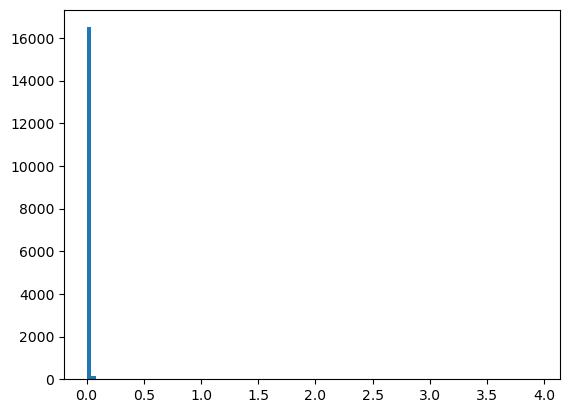

In [41]:
plt.hist(np.array(flat_min_array), bins = 100);

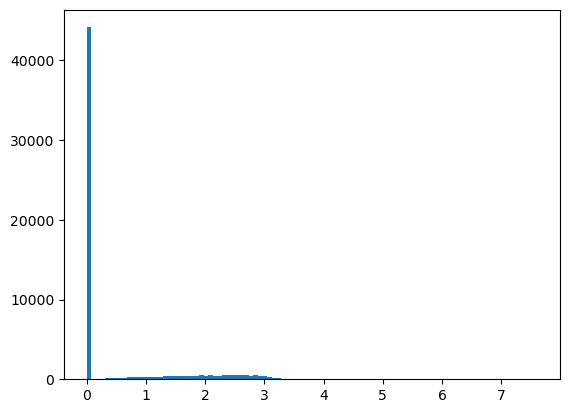

In [44]:
plt.hist(flatten_min_array(dR_before_lead), bins = 100);

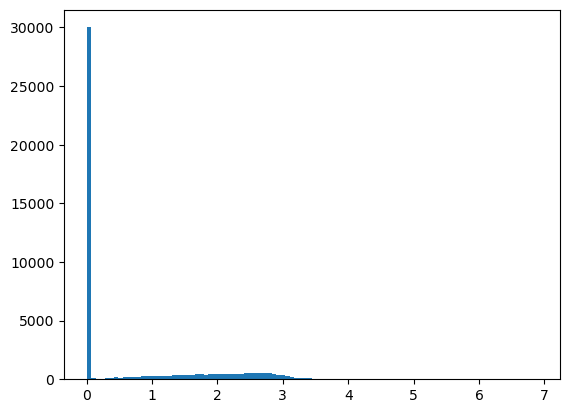

In [45]:
plt.hist(flatten_min_array(dR_before_sublead), bins = 100);

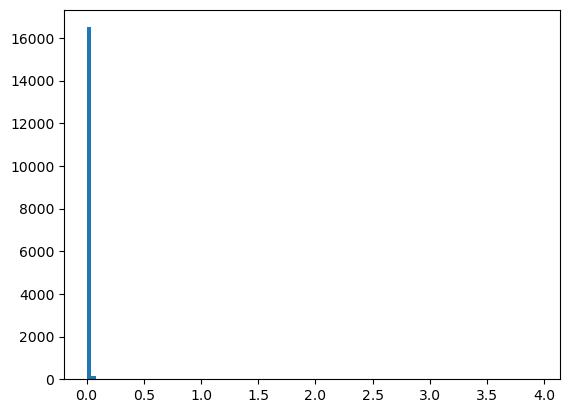

In [46]:
plt.hist(flatten_min_array(dR_after_lead), bins = 100);

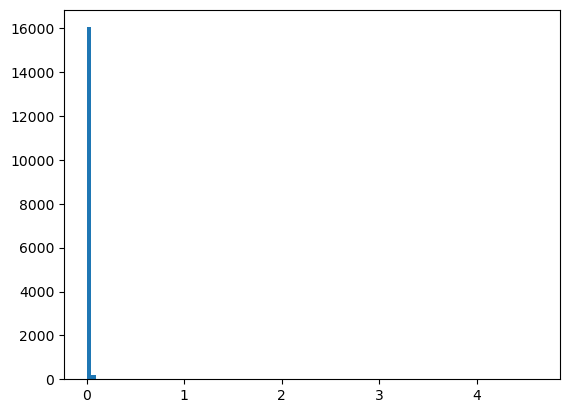

In [47]:
plt.hist(flatten_min_array(dR_after_sublead), bins = 100);

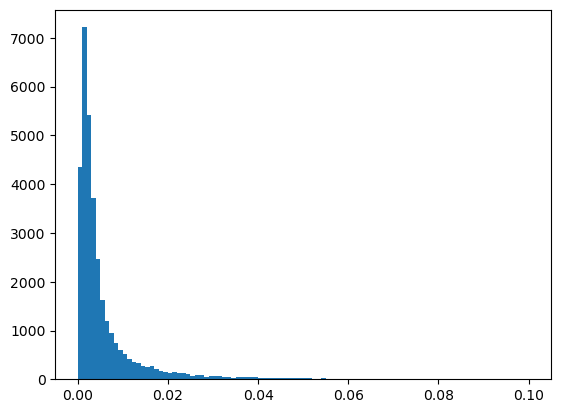

In [23]:
plt.hist(ak.flatten(ak.flatten(dR_after)), range= (0, 0.1),bins = 100);